In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class PreferenceModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LfHPAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64, target_update=10):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.preference_model = PreferenceModel(self.state_dim, 1)
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.preference_optimizer = optim.Adam(self.preference_model.parameters(), lr=alpha)
        self.update_target_model()
        self.target_update = target_update
        self.steps_done = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

        q_values = self.model(state_batch).gather(1, action_batch)
        next_q_values = self.target_model(next_state_batch).max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_human_preference(self, state1, action1, state2, action2):
        # Simulate human preference
        reward1 = -1 if abs(state1[0, 2]) > 0.1 else 1
        reward2 = -1 if abs(state2[0, 2]) > 0.1 else 1
        return reward1 > reward2

    def update_preference_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state1, action1, reward1, next_state1, done1 in batch:
            state2, action2, reward2, next_state2, done2 = random.choice(self.memory)
            action1 = torch.FloatTensor([action1]).unsqueeze(0)
            action2 = torch.FloatTensor([action2]).unsqueeze(0)
            state1 = torch.FloatTensor(state1).unsqueeze(0)
            state2 = torch.FloatTensor(state2).unsqueeze(0)
            preference = self.get_human_preference(state1, action1, state2, action2)

            pred1 = self.preference_model(state1, action1)
            pred2 = self.preference_model(state2, action2)
            preference_target = torch.FloatTensor([[1.0], [0.0]]) if preference else torch.FloatTensor([[0.0], [1.0]])

            loss = nn.BCEWithLogitsLoss()(torch.cat((pred1, pred2)), preference_target)
            self.preference_optimizer.zero_grad()
            loss.backward()
            self.preference_optimizer.step()

def train(env, agent, episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            agent.update_preference_model()
            state = next_state
            total_reward += reward

            if episode % agent.target_update == 0:
                agent.update_target_model()

        rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return rewards

# Main function to run the training
def main():
    env = gym.make('CartPole-v1')
    agent = LfHPAgent(env)
    episodes = 200  # Increased number of episodes
    rewards = train(env, agent, episodes)

    # Plot the rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences')
    plt.show()

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/200, Total Reward: 27.0, Evaluation Reward: 9.5
Episode 2/200, Total Reward: 18.0, Evaluation Reward: 9.3


<ipython-input-1-7ecebfee7dcb>:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state_batch = torch.FloatTensor(state_batch)


Episode 3/200, Total Reward: 23.0, Evaluation Reward: 9.4
Episode 4/200, Total Reward: 31.0, Evaluation Reward: 9.4
Episode 5/200, Total Reward: 33.0, Evaluation Reward: 21.9
Episode 6/200, Total Reward: 29.0, Evaluation Reward: 34.0
Episode 7/200, Total Reward: 36.0, Evaluation Reward: 13.5
Episode 8/200, Total Reward: 18.0, Evaluation Reward: 14.1
Episode 9/200, Total Reward: 24.0, Evaluation Reward: 14.4
Episode 10/200, Total Reward: 20.0, Evaluation Reward: 14.7
Episode 11/200, Total Reward: 33.0, Evaluation Reward: 9.1
Episode 12/200, Total Reward: 15.0, Evaluation Reward: 9.2
Episode 13/200, Total Reward: 13.0, Evaluation Reward: 9.0
Episode 14/200, Total Reward: 10.0, Evaluation Reward: 9.7
Episode 15/200, Total Reward: 12.0, Evaluation Reward: 9.3
Episode 16/200, Total Reward: 15.0, Evaluation Reward: 9.4
Episode 17/200, Total Reward: 10.0, Evaluation Reward: 9.2
Episode 18/200, Total Reward: 10.0, Evaluation Reward: 9.6
Episode 19/200, Total Reward: 10.0, Evaluation Reward: 9.

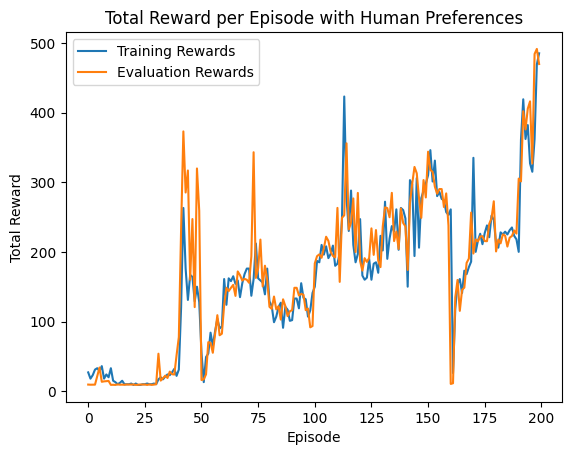

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class PreferenceModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LfHPAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64, target_update=10):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.preference_model = PreferenceModel(self.state_dim, 1)
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.preference_optimizer = optim.Adam(self.preference_model.parameters(), lr=alpha)
        self.update_target_model()
        self.target_update = target_update
        self.steps_done = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

        q_values = self.model(state_batch).gather(1, action_batch)
        next_q_values = self.target_model(next_state_batch).max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_human_preference(self, state1, action1, state2, action2):
        # Simulate human preference
        reward1 = -1 if abs(state1[0, 2]) > 0.1 else 1
        reward2 = -1 if abs(state2[0, 2]) > 0.1 else 1
        return reward1 > reward2

    def update_preference_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state1, action1, reward1, next_state1, done1 in batch:
            state2, action2, reward2, next_state2, done2 = random.choice(self.memory)
            action1 = torch.FloatTensor([action1]).unsqueeze(0)
            action2 = torch.FloatTensor([action2]).unsqueeze(0)
            state1 = torch.FloatTensor(state1).unsqueeze(0)
            state2 = torch.FloatTensor(state2).unsqueeze(0)
            preference = self.get_human_preference(state1, action1, state2, action2)

            pred1 = self.preference_model(state1, action1)
            pred2 = self.preference_model(state2, action2)
            preference_target = torch.FloatTensor([[1.0], [0.0]]) if preference else torch.FloatTensor([[0.0], [1.0]])

            loss = nn.BCEWithLogitsLoss()(torch.cat((pred1, pred2)), preference_target)
            self.preference_optimizer.zero_grad()
            loss.backward()
            self.preference_optimizer.step()

def train(env, agent, episodes):
    rewards = []
    eval_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            agent.update_preference_model()
            state = next_state
            total_reward += reward

            if episode % agent.target_update == 0:
                agent.update_target_model()

        rewards.append(total_reward)

        # Evaluation phase
        eval_reward = evaluate(env, agent, episodes=10)
        eval_rewards.append(eval_reward)

        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Evaluation Reward: {eval_reward}")
    return rewards, eval_rewards

def evaluate(env, agent, episodes=10):
    total_rewards = []
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # No exploration during evaluation
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    agent.epsilon = original_epsilon
    return np.mean(total_rewards)

# Main function to run the training
def main():
    env = gym.make('CartPole-v1')
    agent = LfHPAgent(env)
    episodes = 200  # Increased number of episodes
    rewards, eval_rewards = train(env, agent, episodes)

    # Plot the rewards
    plt.plot(rewards, label='Training Rewards')
    plt.plot(eval_rewards, label='Evaluation Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
